In [126]:
# import dependancies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mpld3
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor


## Data Import and Clean

In [2]:
# import data from csv using pandas
data = pd.read_csv('data/decaydata.csv')

# drop blank rows
data.dropna(inplace=True)

# add calculated column for decay over 30 minutes
data['30 min decay'] = data["T0"]-data["T0.5"]

# add calculated column for SUVA
data["SUVA"] = data["UVA"]/data["FOC"]*100

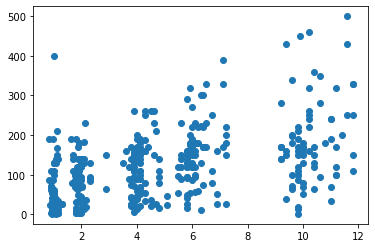

In [3]:
# intitial view of data
plt.scatter(data["Dose Rate (mg/L)"],data["TTHM"])
plt.show()

In [4]:
# find outlier
outlier = data[(data['TTHM'] > 300) & (data['Dose Rate (mg/L)'] < 2)]
outlier

,Code,Date,T0,T0.5,Dose Rate (mg/L),CHCl3,CHCl2Br,CHClBr2,CHBr3,TTHM,pH,COND,Turb,Cl,Br,COLOUR,FOC,UVA,30 min decay,SUVA
291,SW23,14/05/2021,9.6,7.7,1.0,370,25,1,1,400,7.27,8.0,4.2,14.0,0.03,13.0,5.8,0.11,1.9,1.896552


In [276]:
# remove outlier
cleaneddata = data[(data["Code"] != "SW23")]

In [277]:
# divide into surface water (SW) and ground water (GW)
SW = cleaneddata[cleaneddata["Code"].str.contains('SW')==True]
GW = cleaneddata[cleaneddata["Code"].str.contains('GW')==True]

In [278]:
# save to csv    
SW.to_csv("SW_Data.csv", encoding = "utf-8", index=False)
GW.to_csv("GW_Data.csv", encoding = "utf-8", index=False)

## Data Exploration

In [279]:
# summary statistics for SW
SW.describe()

,T0,T0.5,Dose Rate (mg/L),CHCl3,CHCl2Br,CHClBr2,CHBr3,TTHM,pH,COND,Turb,Cl,Br,COLOUR,FOC,UVA,30 min decay,SUVA
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,4.598966,3.882457,4.623190,30.219828,37.241379,45.099138,28.008621,140.504310,7.550043,44.224138,0.839009,94.073276,0.217198,3.219828,3.191810,0.038323,0.716509,1.150252
std,3.321217,3.161091,3.345441,37.464661,31.422583,29.907268,20.104487,89.075725,0.596956,23.929039,0.927965,53.803223,0.151824,5.637609,2.023471,0.039776,1.168951,0.459464
min,0.720000,0.040000,0.810000,1.000000,1.000000,1.000000,1.000000,3.000000,6.640000,7.000000,0.100000,14.000000,0.020000,1.000000,0.500000,0.006000,-1.500000,0.600000
25%,1.795000,1.107500,1.800000,5.000000,11.750000,24.750000,14.750000,78.500000,7.170000,27.000000,0.300000,65.000000,0.070000,1.000000,1.500000,0.016000,0.100000,0.838235
50%,4.000000,3.350000,4.000000,15.000000,32.500000,39.000000,26.000000,130.000000,7.430000,34.000000,0.500000,75.000000,0.240000,1.000000,2.400000,0.027000,0.500000,1.071429
75%,6.225000,5.800000,6.400000,38.500000,52.250000,62.250000,37.000000,175.500000,7.810000,59.000000,0.900000,110.000000,0.300000,3.000000,4.600000,0.049000,1.065000,1.218750
max,12.000000,12.400000,11.800000,190.000000,180.000000,130.000000,110.000000,500.000000,9.430000,122.000000,4.900000,280.000000,0.600000,39.000000,10.000000,0.260000,8.700000,2.600000


In [280]:
# summary statistics for GW
GW.describe()

,T0,T0.5,Dose Rate (mg/L),CHCl3,CHCl2Br,CHClBr2,CHBr3,TTHM,pH,COND,Turb,Cl,Br,COLOUR,FOC,UVA,30 min decay,SUVA
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,4.610529,2.787235,4.643118,11.635294,14.670588,20.082353,28.082353,73.952941,7.130588,120.911765,6.429412,280.323529,0.778824,13.647059,1.682353,0.064588,1.823294,3.122950
std,3.291894,2.776574,3.296362,26.665514,21.783164,23.203862,41.203697,75.581283,0.697073,73.290929,10.316257,211.790859,0.588287,28.083648,1.005156,0.069943,1.719025,2.223086
min,0.870000,0.000000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,5.890000,34.000000,0.100000,34.000000,0.040000,1.000000,0.500000,0.001000,-1.000000,0.200000
25%,1.835000,0.665000,1.820000,1.000000,1.000000,2.000000,2.000000,12.500000,6.640000,60.000000,0.200000,115.000000,0.240000,1.000000,1.300000,0.030000,0.480000,2.294118
50%,4.100000,1.665000,4.000000,2.500000,4.000000,9.500000,12.500000,42.500000,6.970000,84.000000,0.750000,155.000000,0.460000,3.000000,1.500000,0.040000,1.250000,2.602564
75%,6.100000,4.600000,6.100000,7.000000,16.500000,33.000000,32.500000,127.500000,7.910000,198.000000,9.600000,470.000000,1.400000,7.000000,1.800000,0.053000,3.200000,3.615385
max,12.000000,11.200000,11.800000,220.000000,120.000000,98.000000,230.000000,330.000000,8.110000,242.000000,38.000000,680.000000,1.800000,120.000000,4.400000,0.240000,6.200000,11.875000


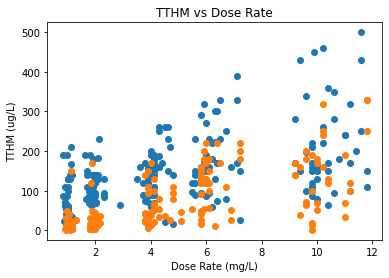

In [281]:
# SW vs GW TTHM/dose rate chart 
plt.scatter(SW["Dose Rate (mg/L)"],SW["TTHM"])
plt.scatter(GW["Dose Rate (mg/L)"],GW["TTHM"])
plt.xlabel('Dose Rate (mg/L)')
plt.ylabel('TTHM (ug/L)')
plt.title('TTHM vs Dose Rate')
plt.show()


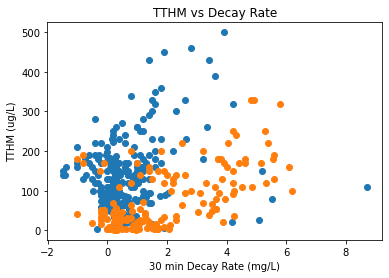

In [282]:
# SW vs GW TTHM/decay rate chart
plt.scatter(SW["30 min decay"],SW["TTHM"])
plt.scatter(GW["30 min decay"],GW["TTHM"])
plt.xlabel('30 min Decay Rate (mg/L)')
plt.ylabel('TTHM (ug/L)')
plt.title('TTHM vs Decay Rate')
plt.savefig("static/data/decayrate.png",bbox_inches='tight')
plt.show()

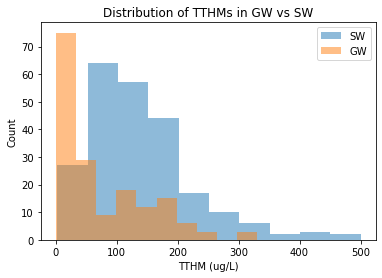

In [283]:
# SW vs GW TTHM histrogram
plt.hist(SW["TTHM"], 10, alpha=0.5, label='SW')
plt.hist(GW["TTHM"], 10, alpha=0.5, label='GW')
plt.legend(loc='upper right')
plt.xlabel('TTHM (ug/L)')
plt.ylabel('Count')
plt.title('Distribution of TTHMs in GW vs SW')
plt.savefig("static/data/tthm.png",bbox_inches='tight')
plt.show()

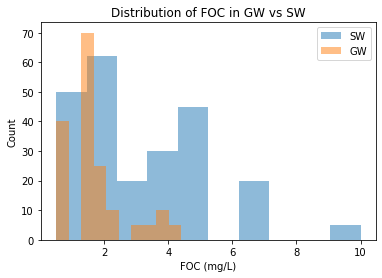

In [284]:
# SW vs GW FOC histrogram
plt.hist(SW["FOC"], 10, alpha=0.5, label='SW')
plt.hist(GW["FOC"], 10, alpha=0.5, label='GW')
plt.legend(loc='upper right')
plt.xlabel('FOC (mg/L)')
plt.ylabel('Count')
plt.title('Distribution of FOC in GW vs SW')
plt.savefig("static/data/foc.png",bbox_inches='tight')
plt.show()

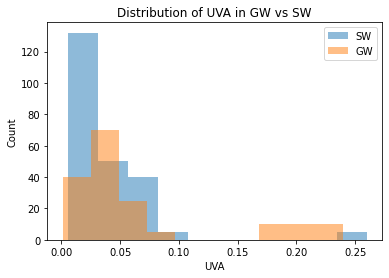

In [285]:
# SW vs GW UVA histrogram
plt.hist(SW["UVA"], 10, alpha=0.5, label='SW')
plt.hist(GW["UVA"], 10, alpha=0.5, label='GW')
plt.legend(loc='upper right')
plt.xlabel('UVA')
plt.ylabel('Count')
plt.title('Distribution of UVA in GW vs SW')
plt.savefig("static/data/uva.png",bbox_inches='tight')
plt.show()

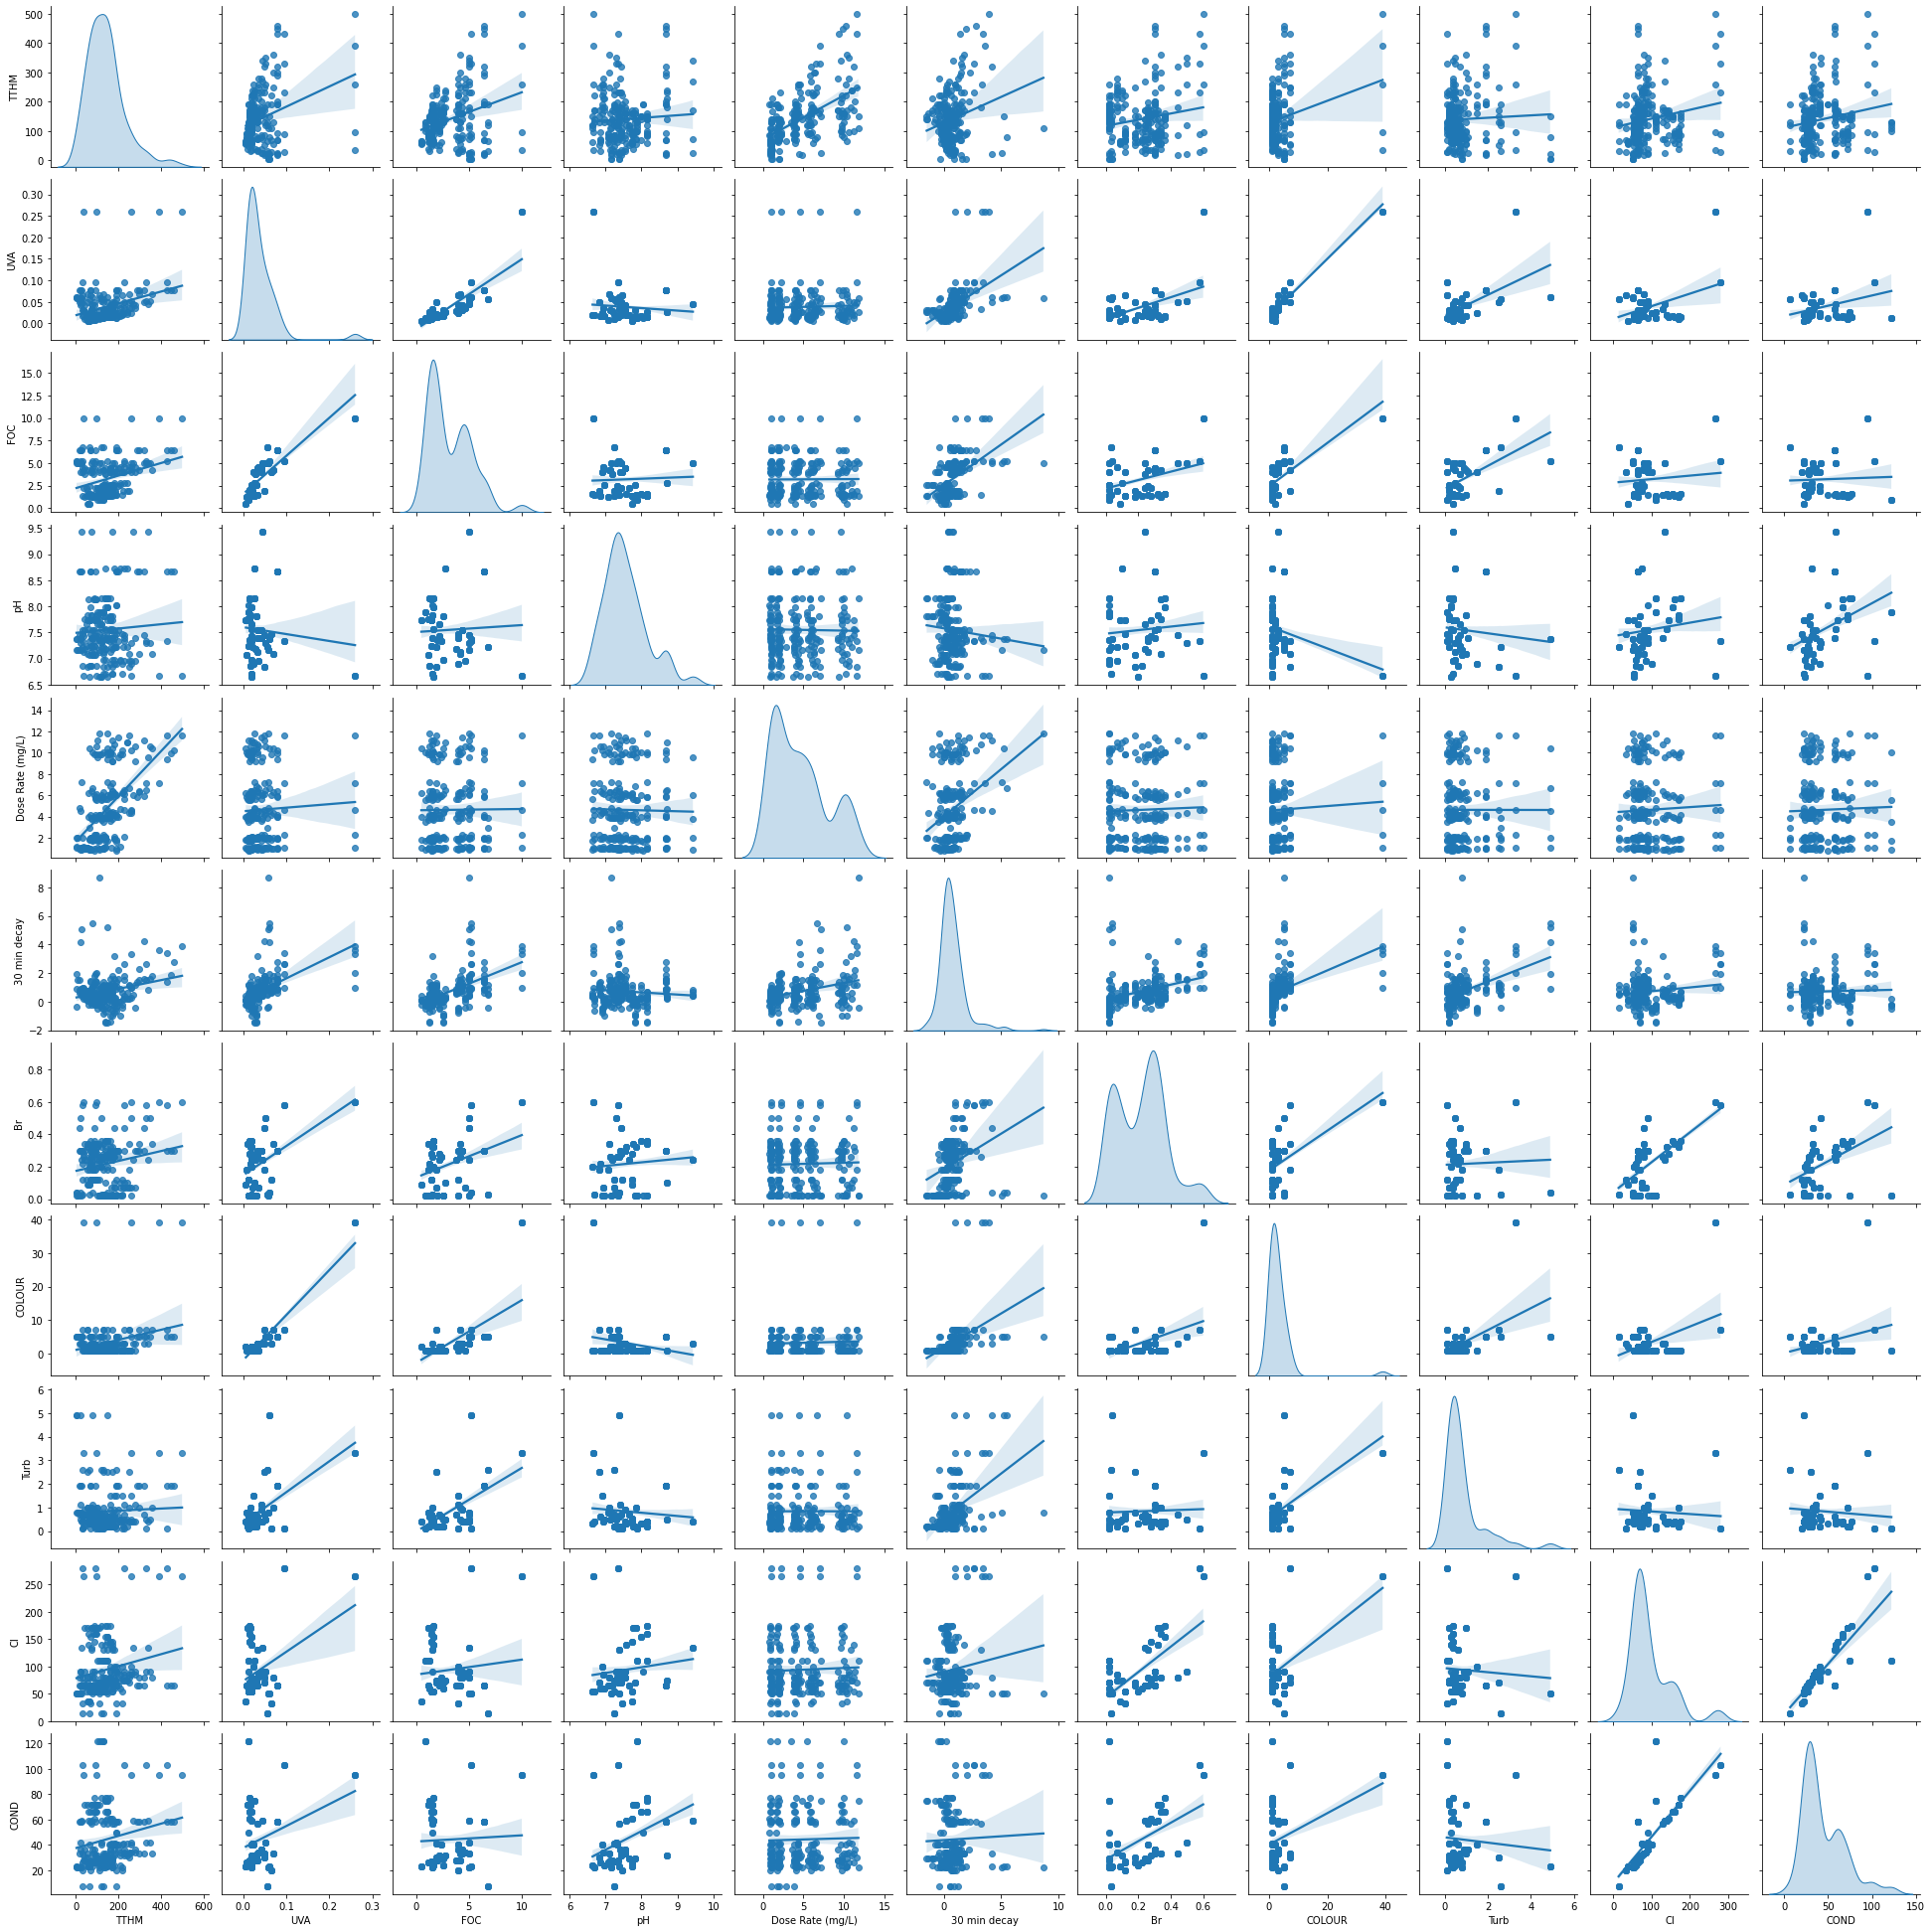

In [17]:
# view all parameters
train_dataset = SW[["UVA","FOC","pH","Dose Rate (mg/L)","30 min decay","Br","COLOUR","Turb","Cl","COND"]].copy()
train_dataset.insert(0, "TTHM", SW["TTHM"])
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

As seen above the paramaters that appear to have a correlation individually with TTHM are UVA, FOC and Dose Rate

All parameters appear to be skewed therefore scaling will be required

## Regression Models

### Surface Water

In [286]:
# create X and Y
X_SW = SW[["UVA","FOC","pH","Dose Rate (mg/L)","30 min decay","Br","COLOUR","Turb","Cl","COND"]]
y_SW = SW["TTHM"].values.reshape(-1, 1)

In [287]:
# initial X, Y split
X_SW_train, X_SW_test, y_SW_train, y_SW_test = train_test_split(X_SW, y_SW, random_state=42)

In [288]:
# Standard scaling
X_SW_scaler = StandardScaler().fit(X_SW_train)

X_SW_train_scaled = X_SW_scaler.transform(X_SW_train)
X_SW_test_scaled = X_SW_scaler.transform(X_SW_test)

In [339]:
print(len(X_SW_train))
print(len(X_SW_test))

174
58


### Linear Regression

In [338]:
# Multilinear regression model
MLR_SW = LinearRegression()
MLR_SW.fit(X_SW_train_scaled, y_SW_train)

# R2
training_score_MLR_SW = MLR_SW.score(X_SW_train_scaled, y_SW_train)
testing_score_MLR_SW = MLR_SW.score(X_SW_test_scaled, y_SW_test)
print(f"Training Score: {training_score_MLR_SW}")
print(f"Testing Score: {testing_score_MLR_SW}")

# make predictions
y_MLR_SW = MLR_SW.predict(X_SW_test_scaled)


Training Score: 0.4456279798673205
Testing Score: 0.45015699035551393


### Random Forest Regression

In [290]:
## Random Forest Regression
RFR_SW = RandomForestRegressor(n_estimators=100, max_depth=15,random_state=42)
RFR_SW.fit(X_SW_train_scaled,y_SW_train.ravel())

# R2
training_score_RFR_SW = RFR_SW.score(X_SW_train_scaled, y_SW_train)
testing_score_RFR_SW = RFR_SW.score(X_SW_test_scaled, y_SW_test)
print(f"Training Score: {training_score_RFR_SW}")
print(f"Testing Score: {testing_score_RFR_SW}")

# make predictions
y_RFR_SW=RFR_SW.predict(X_SW_test_scaled)


Training Score: 0.9744020684023054
Testing Score: 0.8734436284090163


### Feature List

In [291]:
# list of features
feature_list_SW = list(X_SW.columns)
# importances
importances_RFR_SW = list(RFR_SW.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_SW, importances_RFR_SW)]
# Sort the feature importances by most important first

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Dose Rate (mg/L)     Importance: 0.38
Variable: FOC                  Importance: 0.18
Variable: UVA                  Importance: 0.1
Variable: Br                   Importance: 0.09
Variable: 30 min decay         Importance: 0.07
Variable: pH                   Importance: 0.05
Variable: COND                 Importance: 0.05
Variable: Cl                   Importance: 0.04
Variable: Turb                 Importance: 0.03
Variable: COLOUR               Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]

### Parameter Tuning by Random Search CV

In [292]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum node split
min_samples_split = [2, 5, 10]
# Minimum leaf node
min_samples_leaf = [1, 2, 4]
# boostrap data
bootstrap = [True, False]
# Create grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [293]:
# Create model
RFR_SW_RSCV = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit model
RFR_SW_RSCV.fit(X_SW_train_scaled,y_SW_train.ravel())

# get best parameters and best model
print(RFR_SW_RSCV.best_params_)
RFR_SW_RSCV_best = RFR_SW_RSCV.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [294]:
# r2 for model
training_score_RFR_SW_RSCV_best = RFR_SW_RSCV_best.score(X_SW_train_scaled, y_SW_train)
testing_score_RFR_SW_RSCV_best = RFR_SW_RSCV_best.score(X_SW_test_scaled, y_SW_test)

print(f"Training Score: {training_score_RFR_SW_RSCV_best}")
print(f"Testing Score: {testing_score_RFR_SW_RSCV_best}")

# make prediction
y_RFR_SW_RSCV=RFR_SW_RSCV.predict(X_SW_test_scaled)

Training Score: 0.9999985763085115
Testing Score: 0.8282467592537421


### Parameter Tuning by Grid CV

In [295]:
# parameter grid
tuned_parameters = {'n_estimators': [500, 700, 1000], 
                    'max_depth': [80, 90, 100,120], 
                    'min_samples_split': [1, 2, 3],
                    "max_features" : ["auto", "log2", "sqrt"],
                    "bootstrap"    : [True, False]}
RFR_SW_CV = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
RFR_SW_CV.fit(X_SW_train_scaled, y_SW_train.ravel())

print(RFR_SW_CV.best_params_)

RFR_SW_CV_best = RFR_SW_CV.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\fernb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.75514716 0.75726326 0.75582108
 0.754024   0.75202241 0.75552816        nan        nan        nan
 0.72011672 0.71796581 0.72998173 0.70384109 0.7065252  0.70319877
        nan        nan        nan 0.7322292  0.72230645 0.72624961
 0.70318341 0.70837638 0.7039575         nan        nan        nan
 0.7639841  0.7617724  0.7554015  0.75806478 0.75611422 0.75303449
        nan        nan        nan 0.72591342 0.72397295 0.71755496
 0.71275268 0.70851732 0.70786379        nan        nan        nan
 0.7222808  0.7245662  0.72441019 0.69975591 0.70793144 0.70854219
        nan        nan        nan 0.76050461 0.75948241 0.75568657
 0.75384522 0.74822822 0.75063812        nan        nan        nan
 0.71757689 0.72238679 0.72531845 0.71054516 0.70610596 0.70525007
        nan        nan        nan 0.72192413 0.720363

{'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}


In [296]:
# r2 for model
training_score_RFR_SW_CV_best = RFR_SW_CV_best.score(X_SW_train_scaled, y_SW_train)
testing_score_RFR_SW_CV_best = RFR_SW_CV_best.score(X_SW_test_scaled, y_SW_test)

print(f"Training Score: {training_score_RFR_SW_CV_best}")
print(f"Testing Score: {testing_score_RFR_SW_CV_best}")

# make predictions
y_RFR_SW_CV=RFR_SW_RSCV.predict(X_SW_test_scaled)

Training Score: 0.9747029031009741
Testing Score: 0.8552880268967449


### Gradient Boosting Regression

In [297]:
# Gradient boosting
GBR_SW = GradientBoostingRegressor(random_state=42)

GBR_SW.fit(X_SW_train_scaled, y_SW_train.ravel())

GradientBoostingRegressor(random_state=42)

In [298]:
# R2 for model

training_score_GBR_SW = GBR_SW.score(X_SW_train_scaled, y_SW_train)
testing_score_GBR_SW = GBR_SW.score(X_SW_test_scaled, y_SW_test)

print(f"Training Score: {training_score_GBR_SW}")
print(f"Testing Score: {testing_score_GBR_SW}")

# make predictions
y_GBR_SW=GBR_SW.predict(X_SW_test_scaled)

Training Score: 0.9866408733497116
Testing Score: 0.8843036792117092


In [299]:
# list of features
# feature_list_SW = list(X_SW.columns)
# importances
importances_GBR_SW = list(GBR_SW.feature_importances_)
# List of tuples with variable and importance
feature_importances_GBR_SW = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_SW, importances_GBR_SW)]
# Sort the feature importances by most important first

feature_importances_GBR_SW = sorted(feature_importances_GBR_SW, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_GBR_SW]

Variable: Dose Rate (mg/L)     Importance: 0.37
Variable: FOC                  Importance: 0.24
Variable: UVA                  Importance: 0.09
Variable: Br                   Importance: 0.08
Variable: COND                 Importance: 0.08
Variable: 30 min decay         Importance: 0.05
Variable: Cl                   Importance: 0.04
Variable: pH                   Importance: 0.03
Variable: Turb                 Importance: 0.02
Variable: COLOUR               Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]

### Voting Regressor

In [300]:
# make combined model
VR_SW = VotingRegressor([('gb', GBR_SW), ('rf', RFR_SW), ('lr', MLR_SW)])
VR_SW.fit(X_SW_train_scaled, y_SW_train.ravel())

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_depth=15,
                                                   random_state=42)),
                            ('lr', LinearRegression())])

In [301]:
# r2 for model
training_score_EREG_SW = VR_SW.score(X_SW_train_scaled, y_SW_train)
testing_score_EREG_SW = VR_SW.score(X_SW_test_scaled, y_SW_test)

print(f"Training Score: {training_score_EREG_SW}")
print(f"Testing Score: {testing_score_EREG_SW}")

# make predictions
y_VR_SW=VR_SW.predict(X_SW_test_scaled)

Training Score: 0.9047072859864824
Testing Score: 0.8030370452991429


### Ground Water

In [34]:
# create X and Y
X_GW = GW[["UVA","FOC","pH","Dose Rate (mg/L)","30 min decay","Br","COLOUR","Turb","Cl","COND"]]
y_GW = GW["TTHM"].values.reshape(-1, 1)

In [35]:
# initial X, Y split
X_GW_train, X_GW_test, y_GW_train, y_GW_test = train_test_split(X_GW, y_GW, random_state=42)

In [36]:
# Standard scaling
X_GW_scaler = StandardScaler().fit(X_GW_train)

X_GW_train_scaled = X_GW_scaler.transform(X_GW_train)
X_GW_test_scaled = X_GW_scaler.transform(X_GW_test)

### Linear Regression

In [37]:
# Multilinear regression model
MLR_GW = LinearRegression()
MLR_GW.fit(X_GW_train_scaled, y_GW_train)

# r2 for model
training_score_MLR_GW = MLR_GW.score(X_GW_train_scaled, y_GW_train)
testing_score_MLR_GW = MLR_GW.score(X_GW_test_scaled, y_GW_test)
print(f"Training Score: {training_score_MLR_GW}")
print(f"Testing Score: {testing_score_MLR_GW}")

# make predictions
y_MLR_GW = MLR_GW.predict(X_GW_test_scaled)

Training Score: 0.6310052659239147
Testing Score: 0.6061086334441517


### Random Forest Regression

In [38]:
## Random Forest Regression
RFR_GW = RandomForestRegressor(n_estimators=100, max_depth=15,random_state=42)
RFR_GW.fit(X_GW_train_scaled,y_GW_train.ravel())


RandomForestRegressor(max_depth=15, random_state=42)

In [39]:
# r2 for model
training_score_RFR_GW = RFR_GW.score(X_GW_train_scaled, y_GW_train)
testing_score_RFR_GW = RFR_GW.score(X_GW_test_scaled, y_GW_test)

print(f"Training Score: {training_score_RFR_GW}")
print(f"Testing Score: {testing_score_RFR_GW}")

# make predictions
y_RFR_GW=RFR_GW.predict(X_GW_test_scaled)


Training Score: 0.9662204211195854
Testing Score: 0.6993699462726772


In [40]:
# list of features
feature_list_gw = list(X_GW.columns)
# importances
importances_RFR_GW = list(RFR_GW.feature_importances_)
# List of tuples with variable and importance
feature_importances_GW = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_gw, importances_RFR_GW)]
# Sort the feature importances by most important first

feature_importances_GW = sorted(feature_importances_GW, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_GW]

Variable: Dose Rate (mg/L)     Importance: 0.37
Variable: 30 min decay         Importance: 0.31
Variable: COLOUR               Importance: 0.1
Variable: UVA                  Importance: 0.07
Variable: Br                   Importance: 0.06
Variable: Turb                 Importance: 0.03
Variable: FOC                  Importance: 0.02
Variable: pH                   Importance: 0.02
Variable: Cl                   Importance: 0.01
Variable: COND                 Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]

### Parameter Tuning by Random Search CV

In [41]:
# Create model
RFR_GW_RSCV = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit model
RFR_GW_RSCV.fit(X_GW_train_scaled,y_GW_train.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
# get best parameters and best model
print(RFR_GW_RSCV.best_params_)
RFR_GW_RSCV_best = RFR_GW_RSCV.best_estimator_

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


In [43]:
# r2 for model
training_score_RFR_GW_RSCV_best = RFR_GW_RSCV_best.score(X_GW_train_scaled, y_GW_train)
testing_score_RFR_GW_RSCV_best = RFR_GW_RSCV_best.score(X_GW_test_scaled, y_GW_test)

print(f"Training Score: {training_score_RFR_GW_RSCV_best}")
print(f"Testing Score: {testing_score_RFR_GW_RSCV_best}")

# make predictions
y_RFR_GW_RSCV=RFR_GW_RSCV_best.predict(X_GW_test_scaled)

Training Score: 0.9740350763703338
Testing Score: 0.7364251642044017


### Parameter Tuning by Grid CV

In [44]:
# parameter grid
tuned_parameters_GW = {'n_estimators': [500, 700, 1000], 'max_depth': [80, 90, 100,120], 'min_samples_split': [1, 2, 3],"max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]}
RFR_GW_CV = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
RFR_GW_CV.fit(X_GW_train_scaled, y_GW_train.ravel())


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\fernb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.67506521 0.66501963 0.67630842
 0.6693019  0.66580325 0.67142322        nan        nan        nan
 0.68167128 0.67681268 0.68354209 0.66559166 0.67571286 0.66710433
        nan        nan        nan 0.67878817 0.68188931 0.68738503
 0.67835942 0.67483572 0.67705752        nan        nan        nan
 0.67500165 0.67349935 0.67346869 0.66554414 0.67189625 0.67172037
        nan        nan        nan 0.69574641 0.68897539 0.69327792
 0.66912773 0.67484739 0.67317804        nan        nan        nan
 0.67255836 0.68128967 0.68857653 0.67755676 0.66791659 0.67856135
        nan        nan        nan 0.67035239 0.67245092 0.67414667
 0.66642233 0.66434654 0.67376199        nan        nan        nan
 0.68826991 0.68171436 0.68260836 0.65979717 0.65604008 0.67612467
        nan        nan        nan 0.69293972 0.693361

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [80, 90, 100, 120],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [500, 700, 1000]},
             verbose=1)

In [45]:
# get parameters and best estimator
print(RFR_GW_CV.best_params_)
RFR_GW_CV_best = RFR_GW_CV.best_estimator_

{'bootstrap': False, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}


In [46]:
# r2 for model
training_score_RFR_GW_CV_best = RFR_GW_CV_best.score(X_GW_train_scaled, y_GW_train)
testing_score_RFR_GW_CV_best = RFR_GW_CV_best.score(X_GW_test_scaled, y_GW_test)

print(f"Training Score: {training_score_RFR_GW_CV_best}")
print(f"Testing Score: {testing_score_RFR_GW_CV_best}")

# make predictions
y_RFR_GW_CV=RFR_GW_CV_best.predict(X_GW_test_scaled)

Training Score: 0.9999993757008777
Testing Score: 0.748234205127009


### Gradient Boosting Regression

In [47]:
# Gradient boosting
GBR_GW = GradientBoostingRegressor(random_state=42)
GBR_GW.fit(X_GW_train_scaled, y_GW_train.ravel())

GradientBoostingRegressor(random_state=42)

In [48]:
# r2 for model
training_score_GBR_GW = GBR_GW.score(X_GW_train_scaled, y_GW_train)
testing_score_GBR_GW = GBR_GW.score(X_GW_test_scaled, y_GW_test)

print(f"Training Score: {training_score_GBR_GW}")
print(f"Testing Score: {testing_score_GBR_GW}")

# make predictions
y_GBR_GW=GBR_GW.predict(X_GW_test_scaled)

Training Score: 0.9877885441172417
Testing Score: 0.6377012131692608


### Voting Regressor

In [49]:
# make combined regressor
VR_GW = VotingRegressor([('gb', GBR_GW), ('rf', RFR_GW), ('lr', MLR_GW)])
VR_GW.fit(X_GW_train_scaled, y_GW_train.ravel())

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_depth=15,
                                                   random_state=42)),
                            ('lr', LinearRegression())])

In [51]:
# r2 for model
training_score_EREG_GW = VR_GW.score(X_GW_train_scaled, y_GW_train)
testing_score_EREG_GW = VR_GW.score(X_GW_test_scaled, y_GW_test)

print(f"Training Score: {training_score_EREG_GW}")
print(f"Testing Score: {testing_score_EREG_GW}")

# make predictions
y_VR_GW=VR_GW.predict(X_GW_test_scaled)

Training Score: 0.9262361532841328
Testing Score: 0.6841171724753619


## Model Comparisons

### R2 comparisions

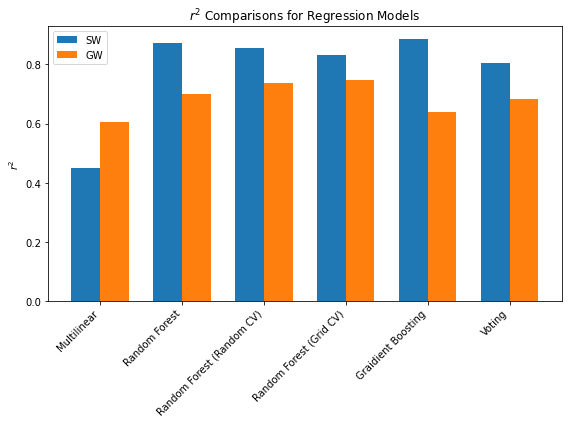

In [179]:
# plot r2s

models = ('Multilinear', 'Random Forest', 'Random Forest (Random CV)', 'Random Forest (Grid CV)', 'Graidient Boosting', 'Voting')
tick_locations = np.arange(len(models))
R2_scores_SW = [testing_score_MLR_SW,testing_score_RFR_SW,testing_score_RFR_SW_RSCV_best,testing_score_RFR_SW_CV_best,testing_score_GBR_SW,testing_score_EREG_SW]
R2_scores_GW = [testing_score_MLR_GW,testing_score_RFR_GW,testing_score_RFR_GW_RSCV_best,testing_score_RFR_GW_CV_best,testing_score_GBR_GW,testing_score_EREG_GW]

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(tick_locations - 0.35/2, R2_scores_SW, 0.35, label='SW')
rects2 = ax.bar(tick_locations + 0.35/2, R2_scores_GW, 0.35, label='GW')

ax.set_ylabel('$r^{2}$')
ax.set_title('$r^{2}$ Comparisons for Regression Models')
ax.set_xticks(tick_locations)
ax.set_xticklabels(models, rotation=45,horizontalalignment="right")
ax.legend()

fig.tight_layout()
plt.savefig("static/data/r2bar.png",bbox_inches='tight')
plt.show()



### SW Predictions vs Actual

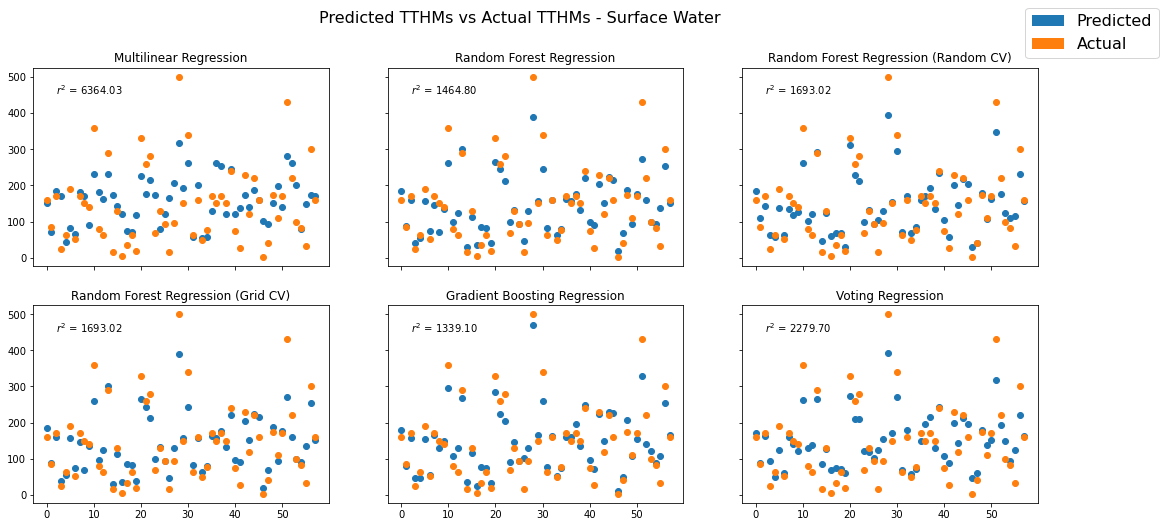

In [336]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True,figsize = (18,8))


axs[0, 0].scatter(np.arange(len(y_MLR_SW)),y_MLR_SW.ravel())
axs[0, 0].scatter(np.arange(len(y_MLR_SW)),y_SW_test.ravel())
axs[0, 0].set_title("Multilinear Regression")
axs[0, 0].annotate(f"$r^{2}$ = {R2_scores_SW[0]:.2f}",xy=(2, 450))

axs[0, 1].scatter(np.arange(len(y_RFR_SW_RSCV)),y_RFR_SW_RSCV.ravel())
axs[0, 1].scatter(np.arange(len(y_RFR_SW_RSCV)),y_SW_test.ravel())
axs[0, 1].set_title("Random Forest Regression")
axs[0, 1].annotate(f"$r^{2}$ = {R2_scores_SW[1]:.2f}",xy=(2, 450))

axs[0, 2].scatter(np.arange(len(y_RFR_SW)),y_RFR_SW.ravel())
axs[0, 2].scatter(np.arange(len(y_RFR_SW)),y_SW_test.ravel())
axs[0, 2].set_title("Random Forest Regression (Random CV)")
axs[0, 2].annotate(f"$r^{2}$ = {R2_scores_SW[2]:.2f}",xy=(2, 450))

axs[1, 0].scatter(np.arange(len(y_RFR_SW_CV)),y_RFR_SW_CV.ravel())
axs[1, 0].scatter(np.arange(len(y_RFR_SW_CV)),y_SW_test.ravel())
axs[1, 0].set_title("Random Forest Regression (Grid CV)")
axs[1, 0].annotate(f"$r^{2}$ = {R2_scores_SW[3]:.2f}",xy=(2, 450))

axs[1, 1].scatter(np.arange(len(y_GBR_SW)),y_GBR_SW.ravel())
axs[1, 1].scatter(np.arange(len(y_GBR_SW)),y_SW_test.ravel())
axs[1, 1].set_title("Gradient Boosting Regression")
axs[1, 1].annotate(f"$r^{2}$ = {R2_scores_SW[4]:.2f}",xy=(2, 450))

axs[1, 2].scatter(np.arange(len(y_VR_SW)),y_VR_SW.ravel())
axs[1, 2].scatter(np.arange(len(y_VR_SW)),y_SW_test.ravel())
axs[1, 2].set_title("Voting Regression")
axs[1, 2].annotate(f"$r^{2}$ = {R2_scores_SW[5]:.2f}",xy=(2, 450))
ax.legend()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ["Predicted","Actual"], loc='upper right',fontsize=16)

fig.suptitle("Predicted TTHMs vs Actual TTHMs - Surface Water", fontsize=16)

plt.savefig("static/data/predsw.png",bbox_inches='tight')
plt.show()

html_str = mpld3.fig_to_html(fig)
Html_file= open("Predictions_SW.html","w")
Html_file.write(html_str)
Html_file.close()


## Mean Squared Error SW Models

In [224]:
MSE_MLR_SW = np.sum((y_MLR_SW-y_SW_test)*(y_MLR_SW-y_SW_test))/len((y_MLR_SW))  
MSE_RFR_SW_RSCV = np.sum((y_RFR_SW_RSCV-y_SW_test.ravel())*(y_RFR_SW_RSCV-y_SW_test.ravel()))/len((y_RFR_SW_RSCV))
MSE_RFR_SW = np.sum((y_RFR_SW-y_SW_test.ravel())*(y_RFR_SW-y_SW_test.ravel()))/len((y_RFR_SW))
MSE_RFR_SW_CV = np.sum((y_RFR_SW_CV-y_SW_test.ravel())*(y_RFR_SW_CV-y_SW_test.ravel()))/len((y_RFR_SW_CV))
MSE_GBR_SW = np.sum((y_GBR_SW-y_SW_test.ravel())*(y_GBR_SW-y_SW_test.ravel()))/len((y_GBR_SW))
MSE_VR_SW = np.sum((y_VR_SW-y_SW_test.ravel())*(y_VR_SW-y_SW_test.ravel()))/len((y_VR_SW))

print(f'Mean Squared Error Multlinear Regression: {MSE_MLR_SW}')
print(f'Mean Squared Error Random Forest (Random CV): {MSE_RFR_SW_RSCV}')
print(f'Mean Squared Error Random Forest: {MSE_RFR_SW}')
print(f'Mean Squared Error Random Forest (Grid CV): {MSE_RFR_SW_CV}')
print(f'Mean Squared Error Gradient Boosting: {MSE_GBR_SW}')
print(f'Mean Squared Error Voting: {MSE_VR_SW}')



Mean Squared Error Multlinear Regression: 6364.034674455529
Mean Squared Error Random Forest (Random CV): 1693.0189385292051
Mean Squared Error Random Forest: 1464.798356896552
Mean Squared Error Random Forest (Grid CV): 1693.0189385292051
Mean Squared Error Gradient Boosting: 1339.101133030102
Mean Squared Error Voting: 2279.703572315913


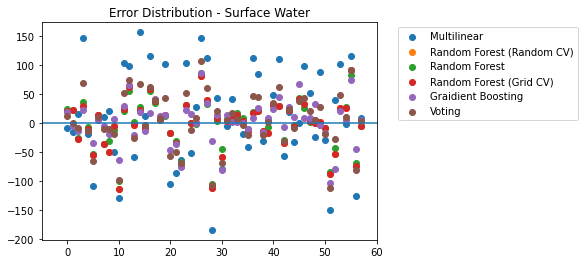

In [247]:
plt.scatter(np.arange(len(y_MLR_SW)),y_MLR_SW-y_SW_test, label=models[0])
plt.scatter(np.arange(len(y_MLR_SW)),y_RFR_SW_RSCV-y_SW_test.ravel(), label=models[2])
plt.scatter(np.arange(len(y_MLR_SW)),y_RFR_SW-y_SW_test.ravel(), label=models[1])
plt.scatter(np.arange(len(y_MLR_SW)),y_RFR_SW_CV-y_SW_test.ravel(), label=models[3])
plt.scatter(np.arange(len(y_MLR_SW)),(y_GBR_SW-y_SW_test.ravel()), label=models[4])
plt.scatter(np.arange(len(y_MLR_SW)),(y_VR_SW-y_SW_test.ravel()), label=models[5])
plt.hlines(0,-100,100)
plt.xlim(-5,60)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Error Distribution - Surface Water")
plt.savefig("static/data/swerror.png",bbox_inches='tight')

plt.show()


### GW Predictions vs Actual

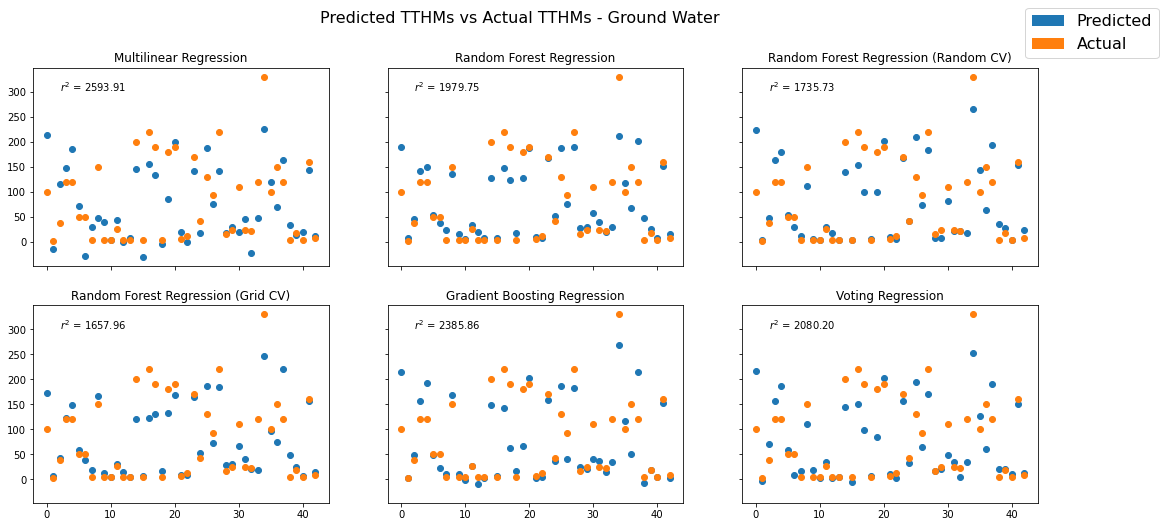

In [249]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True,figsize = (18,8))


axs[0, 0].scatter(np.arange(len(y_MLR_GW)),y_MLR_GW.ravel())
axs[0, 0].scatter(np.arange(len(y_MLR_GW)),y_GW_test.ravel())
axs[0, 0].set_title("Multilinear Regression")
axs[0, 0].annotate(f"$r^{2}$ = {R2_scores_GW[0]:.2f}",xy=(2, 300))

axs[0, 1].scatter(np.arange(len(y_RFR_GW_RSCV)),y_RFR_GW_RSCV.ravel())
axs[0, 1].scatter(np.arange(len(y_RFR_GW_RSCV)),y_GW_test.ravel())
axs[0, 1].set_title("Random Forest Regression")
axs[0, 1].annotate(f"$r^{2}$ = {R2_scores_GW[1]:.2f}",xy=(2, 300))

axs[0, 2].scatter(np.arange(len(y_RFR_GW)),y_RFR_GW.ravel())
axs[0, 2].scatter(np.arange(len(y_RFR_GW)),y_GW_test.ravel())
axs[0, 2].set_title("Random Forest Regression (Random CV)")
axs[0, 2].annotate(f"$r^{2}$ = {R2_scores_GW[2]:.2f}",xy=(2, 300))

axs[1, 0].scatter(np.arange(len(y_RFR_GW_CV)),y_RFR_GW_CV.ravel())
axs[1, 0].scatter(np.arange(len(y_RFR_GW_CV)),y_GW_test.ravel())
axs[1, 0].set_title("Random Forest Regression (Grid CV)")
axs[1, 0].annotate(f"$r^{2}$ = {R2_scores_GW[3]:.2f}",xy=(2, 300))

axs[1, 1].scatter(np.arange(len(y_GBR_GW)),y_GBR_GW.ravel())
axs[1, 1].scatter(np.arange(len(y_GBR_GW)),y_GW_test.ravel())
axs[1, 1].set_title("Gradient Boosting Regression")
axs[1, 1].annotate(f"$r^{2}$ = {R2_scores_GW[4]:.2f}",xy=(2, 300))

axs[1, 2].scatter(np.arange(len(y_VR_GW)),y_VR_GW.ravel())
axs[1, 2].scatter(np.arange(len(y_VR_GW)),y_GW_test.ravel())
axs[1, 2].set_title("Voting Regression")
axs[1, 2].annotate(f"$r^{2}$ = {R2_scores_GW[5]:.2f}",xy=(2, 300))
ax.legend()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ["Predicted","Actual"], loc='upper right',fontsize=16)

fig.suptitle("Predicted TTHMs vs Actual TTHMs - Ground Water", fontsize=16)
plt.savefig("static/data/predgw.png",bbox_inches='tight')
plt.show()

html_str = mpld3.fig_to_html(fig)
Html_file= open("Predictions_GW.html","w")
Html_file.write(html_str)
Html_file.close()


### Mean Squared Error GW Models

In [226]:
MSE_MLR_GW = np.sum(((y_MLR_GW-y_GW_test)*(y_MLR_GW-y_GW_test)))/len((y_MLR_GW))
MSE_RFR_GW_RSCV = np.sum((y_RFR_GW_RSCV-y_GW_test.ravel())*(y_RFR_GW_RSCV-y_GW_test.ravel()))/len((y_RFR_GW_RSCV))
MSE_RFR_GW = np.sum((y_RFR_GW-y_GW_test.ravel())*(y_RFR_GW-y_GW_test.ravel()))/len((y_RFR_GW))
MSE_RFR_GW_CV = np.sum((y_RFR_GW_CV-y_GW_test.ravel())*(y_RFR_GW_CV-y_GW_test.ravel()))/len((y_RFR_GW_CV))
MSE_GBR_GW = np.sum((y_GBR_GW-y_GW_test.ravel())*(y_GBR_GW-y_GW_test.ravel()))/len((y_GBR_GW))
MSE_VR_GW = np.sum((y_VR_GW-y_GW_test.ravel())*(y_VR_GW-y_GW_test.ravel()))/len((y_VR_GW))

print(f'Mean Squared Error Multlinear Regression: {MSE_MLR_GW}')
print(f'Mean Squared Error Random Forest (Random CV): {MSE_RFR_GW_RSCV}')
print(f'Mean Squared Error Random Forest: {MSE_RFR_GW}')
print(f'Mean Squared Error Random Forest (Grid CV): {MSE_RFR_GW_CV}')
print(f'Mean Squared Error Gradient Boosting: {MSE_GBR_GW}')
print(f'Mean Squared Error Voting: {MSE_VR_GW}')

Mean Squared Error Multlinear Regression: 2593.909922441306
Mean Squared Error Random Forest (Random CV): 1735.7308129247936
Mean Squared Error Random Forest: 1979.7521488372092
Mean Squared Error Random Forest (Grid CV): 1657.9642228837206
Mean Squared Error Gradient Boosting: 2385.8619351471766
Mean Squared Error Voting: 2080.196902535561


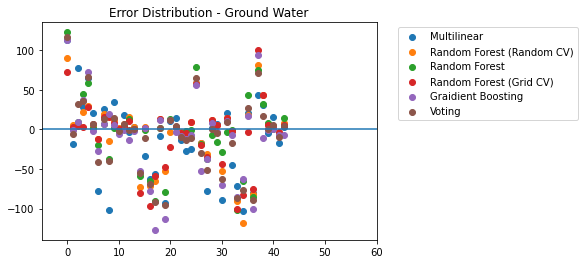

In [248]:
plt.scatter(np.arange(len(y_MLR_GW)),y_MLR_GW-y_GW_test, label=models[0])
plt.scatter(np.arange(len(y_MLR_GW)),y_RFR_GW_RSCV-y_GW_test.ravel(), label=models[2])
plt.scatter(np.arange(len(y_MLR_GW)),y_RFR_GW-y_GW_test.ravel(), label=models[1])
plt.scatter(np.arange(len(y_MLR_GW)),y_RFR_GW_CV-y_GW_test.ravel(), label=models[3])
plt.scatter(np.arange(len(y_MLR_GW)),(y_GBR_GW-y_GW_test.ravel()), label=models[4])
plt.scatter(np.arange(len(y_MLR_GW)),(y_VR_GW-y_GW_test.ravel()), label=models[5])
plt.hlines(0,-100,100)
plt.xlim(-5,60)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Error Distribution - Ground Water")
plt.savefig("static/data/gwerror.png",bbox_inches='tight')

plt.show()

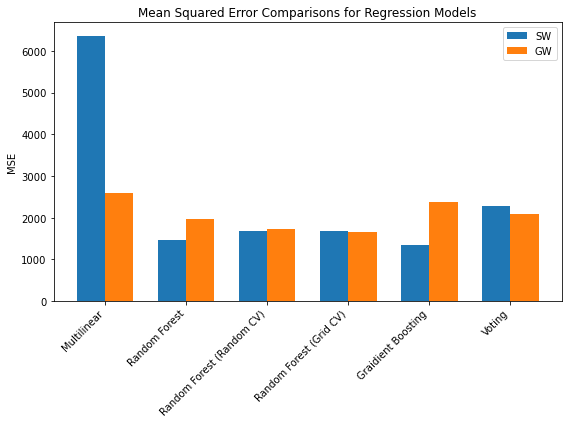

In [227]:
models = ('Multilinear', 'Random Forest', 'Random Forest (Random CV)', 'Random Forest (Grid CV)', 'Graidient Boosting', 'Voting')
tick_locations = np.arange(len(models))
R2_scores_SW = [MSE_MLR_SW,MSE_RFR_SW,MSE_RFR_SW_RSCV,MSE_RFR_SW_CV,MSE_GBR_SW,MSE_VR_SW]
R2_scores_GW = [MSE_MLR_GW,MSE_RFR_GW,MSE_RFR_GW_RSCV,MSE_RFR_GW_CV,MSE_GBR_GW,MSE_VR_GW]

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(tick_locations - 0.35/2, R2_scores_SW, 0.35, label='SW')
rects2 = ax.bar(tick_locations + 0.35/2, R2_scores_GW, 0.35, label='GW')

ax.set_ylabel('MSE')
ax.set_title('Mean Squared Error Comparisons for Regression Models')
ax.set_xticks(tick_locations)
ax.set_xticklabels(models, rotation=45,horizontalalignment="right")
ax.legend()

fig.tight_layout()
plt.savefig("static/data/msebar.png",bbox_inches='tight')
plt.show()

## Trimming Parameters

### Identifying important features for best SW model (Gradient Boosting)

In [ ]:
# list of important features
# importances
importances_GBR_SW = list(GBR_SW.feature_importances_)
# List of tuples with variable and importance
feature_importances_GBR_SW = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_SW, importances_GBR_SW)]
# Sort the feature importances by most important first

feature_importances_GBR_SW = sorted(feature_importances_GBR_SW, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_GBR_SW]

### Trimming Train and Test SW data to include only important features

In [118]:
# trim split arrays to only include UVA, FOC and Dose Rate

X_SW_train_scaled_trimmed = [[item[0],item[1],item[3]] for item in X_SW_train_scaled]
X_SW_test_scaled_trimmed = [[item[0],item[1],item[3]] for item in X_SW_test_scaled]

### Trimmed SW Model

In [119]:
# Gradient boosting with trimmed parameters
GBR_SW_Trimmed = GradientBoostingRegressor(random_state=42)

GBR_SW_Trimmed.fit(X_SW_train_scaled_trimmed, y_SW_train.ravel())

GradientBoostingRegressor(random_state=42)

In [120]:
# R2 for model

training_score_GBR_SW_Trimmed = GBR_SW_Trimmed.score(X_SW_train_scaled_trimmed, y_SW_train)
testing_score_GBR_SW_Trimmed = GBR_SW_Trimmed.score(X_SW_test_scaled_trimmed, y_SW_test)

print(f"Training Score: {training_score_GBR_SW_Trimmed}")
print(f"Testing Score: {testing_score_GBR_SW_Trimmed}")

# make predictions
y_GBR_SW_Trimmed=GBR_SW_Trimmed.predict(X_SW_test_scaled_trimmed)

Training Score: 0.9524041653957354
Testing Score: 0.8321133263126488


In [315]:
MSE_Trimmed_SW = np.sum((y_GBR_SW_Trimmed-y_SW_test.ravel())*(y_GBR_SW_Trimmed-y_SW_test.ravel()))/len((y_GBR_SW_Trimmed))
print(f'Mean Squared Error Trimmed Regression: {MSE_Trimmed_SW}')

Mean Squared Error Trimmed Regression: 1943.1666748225587


<function matplotlib.pyplot.show(close=None, block=None)>

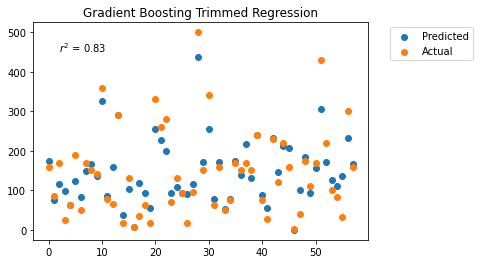

In [330]:
plt.scatter(np.arange(len(y_GBR_SW_Trimmed.ravel())),y_GBR_SW_Trimmed.ravel(),label="Predicted")
plt.scatter(np.arange(len(y_GBR_SW_Trimmed.ravel())),y_SW_test.ravel(),label="Actual")
plt.annotate(f"$r^{2}$ = {testing_score_GBR_SW_Trimmed:.2f}",xy=(2, 450))
plt.title("Gradient Boosting Trimmed Regression")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("static/data/trimmedpred.png",bbox_inches='tight')
plt.show

The trimming of unimportant paramaters from the Gradient Boosting Model reduced r2 from 0.88 to 0.83 which is an acceptable trade off when taking into consideration the cost of analysing the additional parameters

### Identifying important features for best GW model (Random Forest Regression (Grid CV))

In [121]:
# list of features
# importances
importances_RFR_GW_CV_best = list(RFR_GW_CV_best.feature_importances_)
# List of tuples with variable and importance
feature_importances_RFR_GW_CV_best = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_gw, importances_RFR_GW_CV_best)]
# Sort the feature importances by most important first

feature_importances_RFR_GW_CV_best = sorted(feature_importances_RFR_GW_CV_best, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_GW]

Variable: Dose Rate (mg/L)     Importance: 0.37
Variable: 30 min decay         Importance: 0.31
Variable: COLOUR               Importance: 0.1
Variable: UVA                  Importance: 0.07
Variable: Br                   Importance: 0.06
Variable: Turb                 Importance: 0.03
Variable: FOC                  Importance: 0.02
Variable: pH                   Importance: 0.02
Variable: Cl                   Importance: 0.01
Variable: COND                 Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]

### Trimming Train and Test GW data to include only important features

In [122]:
# trim split arrays to only include Colour, 30 min decay and Dose Rate
X_GW_train_scaled_trimmed = [[item[3],item[4],item[6]] for item in X_GW_train_scaled]
X_GW_test_scaled_trimmed = [[item[3],item[4],item[6]] for item in X_GW_test_scaled]

### Trimmed GW Model

In [123]:
RFR_GW_CV_Trimmed = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
RFR_GW_CV_Trimmed.fit(X_GW_train_scaled_trimmed, y_GW_train.ravel())

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\fernb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.61557769 0.61622712 0.62356384
 0.62374882 0.61995705 0.6196892         nan        nan        nan
 0.65282564 0.65994789 0.66663603 0.64925047 0.64585252 0.64260732
        nan        nan        nan 0.65958552 0.65473264 0.65908078
 0.63816842 0.64297061 0.64012645        nan        nan        nan
 0.62549424 0.61170357 0.62061577 0.60663961 0.61401977 0.61719562
        nan        nan        nan 0.65398536 0.6531377  0.65989214
 0.65261227 0.64191866 0.64366062        nan        nan        nan
 0.65973298 0.66408086 0.6522795  0.64749244 0.64608774 0.64222594
        nan        nan        nan 0.6136963  0.62889925 0.61817484
 0.61657924 0.61716084 0.6199802         nan        nan        nan
 0.65406757 0.65610988 0.65525257 0.64713544 0.63409745 0.64234487
        nan        nan        nan 0.64793706 0.658486

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [80, 90, 100, 120],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [500, 700, 1000]},
             verbose=1)

In [124]:
print(RFR_GW_CV_Trimmed.best_params_)
RFR_GW_CV_Trimmed_best = RFR_GW_CV_Trimmed.best_estimator_

{'bootstrap': True, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000}


In [125]:
# r2 for model
training_score_RFR_GW_CV_Trimmed_best = RFR_GW_CV_Trimmed_best.score(X_GW_train_scaled_trimmed, y_GW_train)
testing_score_RFR_GW_CV_Trimmed_best = RFR_GW_CV_Trimmed_best.score(X_GW_test_scaled_trimmed, y_GW_test)

print(f"Training Score: {training_score_RFR_GW_CV_Trimmed_best}")
print(f"Testing Score: {testing_score_RFR_GW_CV_Trimmed_best}")

# make predictions
y_RFR_GW_CV_Trimmed=RFR_GW_CV_Trimmed_best.predict(X_GW_test_scaled_trimmed)

Training Score: 0.9622199663417341
Testing Score: 0.6390005888535105


The trimming of unimportant paramaters from the Random Forrest Regression (Grid CV) Model reduced r2 from 0.75 to 0.64 which is too much of a decrease to consider

## Export Chosen Models

In [128]:
# SW Model
file_SW = 'models/SW_model.pkl'
joblib.dump(GBR_SW, file_SW)

# SW trimmed Model
file_SW_Trimmed = 'models/SW_model_trimmed.pkl'
joblib.dump(GBR_SW_Trimmed, file_SW_Trimmed)

# GW Model
file_GW = 'models/GW_model.pkl'
joblib.dump(RFR_GW_CV_best, file_GW)

# GW trimmed Model
file_GW_Trimmed = 'models/GW_model_trimmed.pkl'
joblib.dump(RFR_GW_CV_Trimmed_best, file_GW_Trimmed)



['models/GW_model_trimmed.pkl']

In [130]:
joblib.dump(X_SW_scaler, 'models/SW_scaler.pkl')
joblib.dump(X_GW_scaler, 'models/GW_scaler.pkl')


['models/GW_scaler.pkl']